## Importing and mapping netCDF data with xarray and cartopy

- read netcdf file into xarray dataset
- subsetting data (using xarray)
- various plot types: contour line, contour fill, vectors, barbs
    

In [1]:
## Imports

import os, sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#import pandas as pd


### Load data

For this example, we are using a netCDF file of 3-hourly ERA5 Reanalysis from 1 March 2019 to 10 March 2019 (10 days) on a 0.5 x 0.5 deg lat-lon grid. Data was downloaded/subset to a regional domain over the Western US/N. Pacific. 

AR lightening occurred on 6 March 2019 (around 4-5 UTC)...

Xarray provides an easy interface for importing and analyzing multidimensional climate data, and is especially useful for handling netCDF files.

In the cell below, we will load the ERA5 netcdf file into an xarray dataset.

In [3]:
# Load data 

filepath = "../sample-data/era5.6hr.20190301-20190310.nc"
# filepath = "era5.6hr.20190301-20190310.nc"
ds = xr.open_dataset(filepath)

print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 71, level: 3, longitude: 121, time: 80)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.5 -149.0 ... -91.0 -90.5 -90.0
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 21.5 21.0 20.5 20.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-01 ... 2019-03-10T21:00:00
Data variables:
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    zg         (time, level, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...


In [4]:
# Select 250-hPa pressure level

ds250 = ds.sel(level='250')
print(ds250)



<xarray.Dataset>
Dimensions:    (latitude: 71, longitude: 121, time: 80)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.5 -149.0 ... -91.0 -90.5 -90.0
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 21.5 21.0 20.5 20.0
    level      float64 250.0
  * time       (time) datetime64[ns] 2019-03-01 ... 2019-03-10T21:00:00
Data variables:
    u          (time, latitude, longitude) float64 ...
    v          (time, latitude, longitude) float64 ...
    zg         (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...


In [5]:
# Select time of storm

ds250 = ds250.sel(time='2019-03-06T06:00:00')
print(ds250)

<xarray.Dataset>
Dimensions:    (latitude: 71, longitude: 121)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.5 -149.0 ... -91.0 -90.5 -90.0
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 21.5 21.0 20.5 20.0
    level      float64 250.0
    time       datetime64[ns] 2019-03-06T06:00:00
Data variables:
    u          (latitude, longitude) float64 ...
    v          (latitude, longitude) float64 ...
    zg         (latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...


In [6]:
# Extract data for plotting

lats = ds250['latitude'].values     # .values extracts var as numpy array
lons = ds250['longitude'].values   
print(lats.shape, lons.shape)

u250 = ds250['u'].values
v250 = ds250['v'].values
z250 = ds250['zg'].values

print(u250.shape)

(71,) (121,)
(71, 121)


In [7]:
# Create function to compute wind speed

def calc_wspd(u, v):
    """Computes wind speed from u and v components"""    
    
    wspd = np.sqrt(u**2 + v**2)   
    
    return wspd


In [8]:
# Calc wspd variable using function

wspd = calc_wspd(u250, v250)


### Plotting with Cartopy

In [11]:
# Set up
uwnd = u250
vwnd = v250
# Projection/Coordinate systems
datacrs = ccrs.PlateCarree()     # data/source
mapcrs = ccrs.PlateCarree()      # map/destination

# Map extent
lonmin = lons.min()
lonmax = lons.max()
latmin = lats.min()
latmax = lats.max()

# Tickmark Locations
dx = np.arange(-150,lonmax+1,30)
dy = np.arange(20,latmax+1,20)
print(dx)
print(dy)


[-150. -120.  -90.]
[20. 40.]


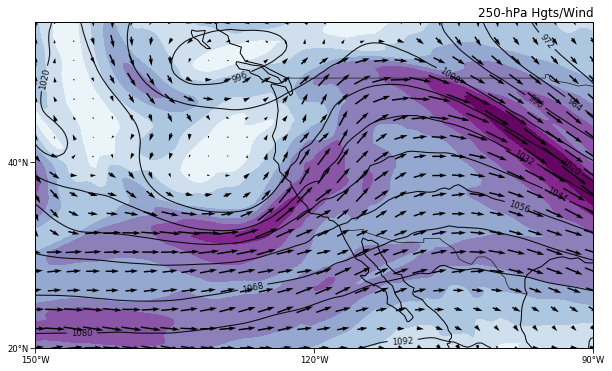

In [18]:
# Create figure
fig = plt.figure(figsize=(10,7)) 

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)



# xticks
ax.set_xticks(dx, crs=mapcrs)      
lon_formatter = LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# yticks
ax.set_yticks(dy, crs=mapcrs)
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
# tick params
ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black')    

# Map features
ax.add_feature(cfeature.LAND, facecolor='0.9') 
ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, z250/10., transform=datacrs,
                levels=clevs_hgts, linewidths=1.1, alpha=0.9,
                colors='k')
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)


# Wind speed - contour fill
#clevs_wspd = np.arange(60,101,10)
cf = ax.contourf(lons, lats, wspd, transform=datacrs,
               #  levels=clevs_wspd, 
                 cmap='BuPu', extend='max')
# Wind vectors 
ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
         color='k', regrid_shape=18, pivot='middle')


# subtitles 
ax.set_title('250-hPa Hgts/Wind', loc='right',fontsize=12)
# ax.set_title(labels[k+1], loc='left',fontsize=12)


# Show
plt.show()

 
    